## Final Project Submission

Please fill out:
* Student name: Nikki Wood
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: Mark Barbour
* Blog post URL:


In [1]:
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import zipfile
import sqlite3
import gzip
import ast
import os
import re


## Business Understanding

Our company is looking to enter the movie production industry by creating a new movie studio. However, we lack experience and insights into what types of films are currently performing well at the box office. The goal of this project is to conduct exploratory data analysis on various movie datasets to uncover trends and patterns that can guide our decision-making process when it comes to selecting the genres, themes, and styles of films to produce.

The key objectives are:

- Analyze box office performance data to identify the most successful and popular movie genres, themes, and styles in recent years.
- Explore factors that contribute to a film's success, such as critical reviews, audience ratings, production budgets, and marketing strategies.
- Generate actionable insights and recommendations for the head of our new movie studio, providing data-driven guidance on the types of films they should consider producing to maximize potential returns.

By leveraging data from reputable sources like Box Office Mojo, IMDB, Rotten Tomatoes, TheMovieDB, and The Numbers, we aim to gain a comprehensive understanding of the current movie landscape and audience preferences. This will enable us to make informed decisions and increase our chances of creating successful and profitable films.

## Data Understanding

Before we dive into analyzing this data, let's get familiar with what we're working with:


In [2]:
# Box Office Mojo
bom_gross = pd.read_csv('zippedData/bom.movie_gross.csv.gz', compression='gzip')

# The Numbers
tn_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz', compression='gzip')

# Rotten T|omatoes
rt_reviews = pd.read_csv('zippedData/rt.reviews.tsv.gz', compression='gzip', sep='\t', encoding='latin-1')
rt_info = pd.read_csv('zippedData/rt.movie_info.tsv.gz', compression='gzip', sep='\t')

# TheMovieDB
tmdb_movies = pd.read_csv('zippedData/tmdb.movies.csv.gz', compression='gzip')

For the IMDB data, which is in a SQLite database, we'll need to connect to it and query the tables we want. It looks like with sqlite database files, we have to extract it first. So lets do that, (and put the temp dir into our git ignore!)

In [3]:
temp_dir = 'temp'
if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)

# Get the current working directory
cwd = os.getcwd()

# Construct the full path to the zipped file
zip_file_path = os.path.join(cwd, 'zippedData', 'im.db.zip')

# Extract zip file to temp dir
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(temp_dir)

# Path to the extracted database file
db_file = os.path.join(temp_dir, 'im.db')

# Connect to the database
conn = sqlite3.connect(db_file)
cursor = conn.cursor()

imdb_basics = pd.read_sql_query("SELECT * FROM movie_basics", conn)


In [4]:
# big boy queries
imdb_ratings_og = pd.read_sql_query("""SELECT
    ib.movie_id,
    ib.primary_title, 
    ib.original_title,
    ib.runtime_minutes,
    ib.genres,
    mr.averagerating,
    mr.numvotes,
    d.primary_name AS director,
    w.primary_name AS writer
FROM
    movie_basics ib
LEFT JOIN
    movie_ratings mr ON ib.movie_id = mr.movie_id  
LEFT JOIN
    (
        SELECT
            d.movie_id,
            p.primary_name
        FROM
            directors d
        JOIN
            persons p ON d.person_id = p.person_id
    ) d ON ib.movie_id = d.movie_id
LEFT JOIN
    (
        SELECT
            w.movie_id, 
            p.primary_name
        FROM
            writers w
        JOIN
            persons p ON w.person_id = p.person_id
    ) w ON ib.movie_id = w.movie_id;
""", conn)

In [5]:
imdb_ratings = imdb_ratings_og # make a copy cuz im tired of waiting for this mf to buffer
imdb_ratings.head()

,movie_id,primary_title,original_title,runtime_minutes,genres,averagerating,numvotes,director,writer
0,tt0063540,Sunghursh,Sunghursh,175.0,"Action,Crime,Drama",7.0,77.0,Harnam Singh Rawail,Abrar Alvi
1,tt0063540,Sunghursh,Sunghursh,175.0,"Action,Crime,Drama",7.0,77.0,Harnam Singh Rawail,Anjana Rawail
2,tt0063540,Sunghursh,Sunghursh,175.0,"Action,Crime,Drama",7.0,77.0,Harnam Singh Rawail,Gulzar
3,tt0063540,Sunghursh,Sunghursh,175.0,"Action,Crime,Drama",7.0,77.0,Harnam Singh Rawail,Mahasweta Devi
4,tt0063540,Sunghursh,Sunghursh,175.0,"Action,Crime,Drama",7.0,77.0,Harnam Singh Rawail,Abrar Alvi


### bom_gross
*Box Office Mojo*

This data provides a high-level financial overview for movies - how much money they made both at home and abroad, as well as which studio put it out and the year it hit theaters. Very useful for analyzing box office performance and studio revenues.

- title - The name/title of the movie
- studio - The production studio behind the movie
- domestic_gross - The total box office revenue earned domestically (within the movie's home country)
- foreign_gross - The total box office revenue earned internationally/overseas
- year - The year the movie was released

### tn_budgets
*The Numbers*

This table has release specifics like dated revenues and ties them back to the production budget. It allows for analysis of how a movie performed versus its budget over different release windows or re-releases.

- release_date - The date this particular release/run hit theaters
- movie - The movie title
- production_budget - The budget/cost to produce this movie
- domestic_gross - Box office revenue earned domestically for this release
- worldwide_gross - Total global box office revenue for this release

### rt_reviews
*Rotten Tomatoes*

This table contains review information, tracking perception of a movie over time.

- review - The actual text content of the movie review
- rating - The numeric rating or score given by the critic (e.g. 3 out of 5 stars)
- fresh - Possibly a binary flag indicating if the review was favorable/fresh or rotten
- critic - The name of the critic who wrote the review
- top_critic - A flag denoting if this is a top/renowned critic or not
- publisher - The publication, website or outlet where the review was published
- date - The date the review was published


### rt_info
*Rotten Tomatoes*

This table holds key attributes for movie info: genre, creators, release dates, etc. Allows us to analyze relationships between a movie's characteristics and its performance. Very valuable for studios doing green-lighting decisions.

- synopsis - A brief summary or description of the movie's plot
- rating - The MPAA rating (G, PG, R, etc.)
- genre - The genre(s) the movie falls under (comedy, action, drama, etc.)
- director - The name(s) of the director(s)
- writer - The writer(s) who wrote the screenplay
- theater_date - The date the movie was released in theaters
- dvd_date - The date the DVD/home video was released
- currency - The currency the box office numbers are in
- box_office - The total box office revenue earned
- runtime - The duration/length of the movie
- studio - The production studio behind the movie

### tmdb_movies
*TheMovieDB*

This looks to be the main movie metadata table. Valuable for knowing what elements resonate with the viewers.

- genre_ids - Likely contains ids representing the different genres a movie belongs to
- id - A unique identifier for each movie
- original_language - The language the movie was originally produced in
- original_title - The original titled the movie was released under
- popularity - Possibly a metric capturing how popular/trending the movie is
- release_date - The date the movie was released in theaters
- title - The title the movie is best known by
- vote_average - The average rating/score the movie received based on audience votes
- vote_count - The number of audience vote/rating entries the average is based on

## Data Preperation and Cleaning


Completeness: Addressing missing or incomplete data entries

Consistency: Ensured uniformity in data formats and representations

Accuracy: Identified and corrected any erroneous or invalid values

Relevance: Filtered out irrelevant or redundant features

To meet these objectives, we will

- Remove unnecessary columns
- Merge the necessary datasets
- Identify columns with missing values and decide whether to drop them
- Split genres column in IMDB and create new columns for each genre ?
- Convert date columns to a consistent format (datetime)
- Remove outliars for relevant information
- check for invalid or out-of-range values
- review merged dataset, drop any irrelevant or redundant columns

In [19]:
# bom_gross
# tn_budgets
# rt_reviews
# rt_info
tmdb_movies

,title,genre_ids,id,original_language,original_title,popularity,release_date,vote_average,vote_count
0,harry potter and the deathly hallows: part 1,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,7.7,10788
1,how to train your dragon,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,7.7,7610
2,iron man 2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,6.8,12368
3,toy story,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,7.9,10174
4,inception,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,8.3,22186
...,...,...,...,...,...,...,...,...,...
26512,laboratory conditions,"[27, 18]",488143,en,Laboratory Conditions,0.600,2018-10-13,0.0,1
26513,_exhibit_84xxx_,"[18, 53]",485975,en,_EXHIBIT_84xxx_,0.600,2018-05-01,0.0,1
26514,the last one,"[14, 28, 12]",381231,en,The Last One,0.600,2018-10-01,0.0,1
26515,trailer made,"[10751, 12, 28]",366854,en,Trailer Made,0.600,2018-06-22,0.0,1


## Identify columns with missing values and decide whether to drop them

In [7]:
# Merge imdb_basics and imdb_ratings
imdb_data = pd.merge(imdb_basics[['movie_id', 'primary_title', 'original_title', 'runtime_minutes', 'genres']],
                     imdb_ratings[['movie_id', 'averagerating', 'numvotes', 'director', 'writer']],
                     on='movie_id',
                     how='inner')

# Fill NaN values with appropriate defaults
imdb_data['averagerating'] = imdb_data['averagerating'].fillna(0.0)
imdb_data['numvotes'] = imdb_data['numvotes'].fillna(0)
imdb_data['director'] = imdb_data['director'].fillna('Unknown')
imdb_data['writer'] = imdb_data['writer'].fillna('Unknown')

# Create a new column 'title' with the original or primary title
imdb_data['is_original_title'] = imdb_data['original_title'].notnull()
imdb_data['title'] = np.where(imdb_data['is_original_title'], imdb_data['original_title'], imdb_data['primary_title'])

In [8]:
# Fill null values in 'original_title' with 'primary_title'
imdb_data['original_title'] = imdb_data['original_title'].fillna(imdb_data['primary_title'])

# Drop rows with null 'runtime_minutes'
imdb_data = imdb_data.dropna(subset=['runtime_minutes'])

# Fill null values in 'genres' with 'Unknown'
imdb_data['genres'] = imdb_data['genres'].fillna('Unknown')

In [9]:
# Preprocessing titles to match!
bom_gross['title'] = bom_gross['title'].str.lower().str.replace('[^a-zA-Z0-9\s]', '')
tn_budgets['title'] = tn_budgets['movie'].str.lower().str.replace('[^a-zA-Z0-9\s]', '')
tmdb_movies['title'] = tmdb_movies['original_title'].str.lower().str.replace('[^a-zA-Z0-9\s]', '')

# Preprocess the 'title' column in imdb_data
imdb_data['title'] = imdb_data['title'].str.lower().str.replace('[^a-zA-Z0-9\s]', '')

# Select and rename columns from each table
bom_gross = bom_gross[['title', 'domestic_gross', 'foreign_gross', 'year']]
tn_budgets = tn_budgets[['title', 'production_budget', 'worldwide_gross']]
tmdb_movies = tmdb_movies[['title', 'genre_ids', 'id', 'original_language', 'original_title', 'popularity', 'release_date', 'vote_average', 'vote_count']]


## Merge the necessary datasets

#### Merging IMDB tables

First, lets move all the data we care about into the same data frame. 



tmdb_movies:
genre_ids id original_language original_title popularity release_date title vote_average vote_count release_year rating_category
  use: original_title

tn_budgets:
id release_date movie production_budget domestic_gross worldwide_gross
  use: movie (should be title), release_date ?

bom_gross:
title studio domestic_gross foreign_gross year
  use: title

---

rt_reviews:
id review rating fresh critic top_critic publisher date
use: not sure :<

rt_info:
id synopsis rating genre director writer theater_date dvd_date currency box_office runtime studio
  use: imdb table 'persons': director, writer (or maybe theater_date ? idk yet)
  
---

Because of this, I'm going to keep these two sets of data seperate.


In [10]:
# Merge the DataFrames using 'title' column and handle duplicates
merged_data = pd.merge(imdb_data, bom_gross, on='title', how='left')
merged_data = pd.merge(merged_data, tn_budgets, on='title', how='inner')  # for budget / word_gross data
merged_data = pd.merge(merged_data, tmdb_movies, on='title', how='left', suffixes=('', '_tmdb'))

# Drop the 'original_title_tmdb' column
merged_data = merged_data.drop(columns=['original_title_tmdb'])

# Print column data types
print("Column Data Types:")
print(merged_data.dtypes)

# Check for duplicate rows
if merged_data.duplicated(subset='title').sum() > 0:
    print("Number of duplicate rows:", merged_data.duplicated(subset='title').sum())
    duplicates = merged_data[merged_data.duplicated(subset='title', keep=False)]
    print("First few duplicate rows:")
    print(duplicates.head())

merged_data = merged_data.drop_duplicates(subset='title', keep='first')

# Check for duplicate rows after dropping duplicates
if merged_data.duplicated(subset='title').sum() > 0:
    print("Number of duplicate rows after dropping duplicates:", merged_data.duplicated(subset='title').sum())
else:
    print("No duplicate rows found after dropping duplicates.")

Column Data Types:
movie_id              object
primary_title         object
original_title        object
runtime_minutes      float64
genres                object
averagerating        float64
numvotes             float64
director              object
writer                object
is_original_title       bool
title                 object
domestic_gross       float64
foreign_gross         object
year                 float64
production_budget     object
worldwide_gross       object
genre_ids             object
id                   float64
original_language     object
popularity           float64
release_date          object
vote_average         float64
vote_count           float64
dtype: object
Number of duplicate rows: 113989
First few duplicate rows:
    movie_id primary_title original_title  runtime_minutes  \
0  tt0249516    Foodfight!     Foodfight!             91.0   
1  tt0249516    Foodfight!     Foodfight!             91.0   
2  tt0249516    Foodfight!     Foodfight!             9

In [11]:
# merged_data = merged_data.dropna()
merged_data.head()

,movie_id,primary_title,original_title,runtime_minutes,genres,averagerating,numvotes,director,writer,is_original_title,...,year,production_budget,worldwide_gross,genre_ids,id,original_language,popularity,release_date,vote_average,vote_count
0,tt0249516,Foodfight!,Foodfight!,91.0,"Action,Animation,Comedy",1.9,8248.0,Lawrence Kasanoff,Brent V. Friedman,True,...,NaN,"$45,000,000","$73,706","[16, 28, 35, 10751]",116977.0,en,4.705,2013-05-07,2.1,46.0
25,tt0326592,The Overnight,The Overnight,88.0,Unknown,7.5,24.0,Jed I. Goodman,Jed I. Goodman,True,...,NaN,"$200,000","$1,165,996","[9648, 35]",308024.0,en,6.576,2015-06-19,6.0,200.0
30,tt0337692,On the Road,On the Road,124.0,"Adventure,Drama,Romance",6.1,37886.0,Walter Salles,Jack Kerouac,True,...,2012.0,"$25,000,000","$9,313,302","[12, 18]",83770.0,en,8.919,2012-12-21,5.6,518.0
39,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,114.0,"Adventure,Comedy,Drama",7.3,275300.0,Ben Stiller,James Thurber,True,...,2013.0,"$91,000,000","$187,861,183","[12, 35, 18, 14]",116745.0,en,10.743,2013-12-25,7.1,4859.0
43,tt0365907,A Walk Among the Tombstones,A Walk Among the Tombstones,114.0,"Action,Crime,Drama",6.5,105116.0,Scott Frank,Lawrence Block,True,...,2014.0,"$28,000,000","$62,108,587","[80, 18, 9648, 53]",169917.0,en,19.373,2014-09-19,6.3,1685.0


#### Merging other datasets: imdb_basics and imdb_ratings

In [12]:
print("Shape of merged_data:", merged_data.shape)
print("Columns of merged_data:", merged_data.columns)
print("Null values in merged_data:\n", merged_data.isnull().sum())

Shape of merged_data: (2216, 23)
Columns of merged_data: Index(['movie_id', 'primary_title', 'original_title', 'runtime_minutes',
       'genres', 'averagerating', 'numvotes', 'director', 'writer',
       'is_original_title', 'title', 'domestic_gross', 'foreign_gross', 'year',
       'production_budget', 'worldwide_gross', 'genre_ids', 'id',
       'original_language', 'popularity', 'release_date', 'vote_average',
       'vote_count'],
      dtype='object')
Null values in merged_data:
 movie_id                0
primary_title           0
original_title          0
runtime_minutes         0
genres                  0
averagerating           0
numvotes                0
director                0
writer                  0
is_original_title       0
title                   0
domestic_gross       1021
foreign_gross        1178
year                 1020
production_budget       0
worldwide_gross         0
genre_ids             415
id                    415
original_language     415
popularity     

In [13]:
# drop row with null values
merged_data = merged_data.dropna()

# Print the number of null values in each column
print("Null values in merged_data:")
print(merged_data.isnull().sum())

# Print the shape of the DataFrame after dropping null values
print("Shape of merged_data after dropping null values:", merged_data.shape)

Null values in merged_data:
movie_id             0
primary_title        0
original_title       0
runtime_minutes      0
genres               0
averagerating        0
numvotes             0
director             0
writer               0
is_original_title    0
title                0
domestic_gross       0
foreign_gross        0
year                 0
production_budget    0
worldwide_gross      0
genre_ids            0
id                   0
original_language    0
popularity           0
release_date         0
vote_average         0
vote_count           0
dtype: int64
Shape of merged_data after dropping null values: (1031, 23)


Hell yeah, that's a win!

In [14]:
print("Column Data Types:")
print(merged_data.dtypes)

Column Data Types:
movie_id              object
primary_title         object
original_title        object
runtime_minutes      float64
genres                object
averagerating        float64
numvotes             float64
director              object
writer                object
is_original_title       bool
title                 object
domestic_gross       float64
foreign_gross         object
year                 float64
production_budget     object
worldwide_gross       object
genre_ids             object
id                   float64
original_language     object
popularity           float64
release_date          object
vote_average         float64
vote_count           float64
dtype: object


## Convert date columns to a consistent format (datetime)

In [15]:
# List of date columns to convert
date_cols = ['release_date']

# Convert date columns to datetime format
for col in date_cols:
    merged_data[col] = pd.to_datetime(merged_data[col], errors='coerce')

# Rotten Tomatoes data
this data doesn't play well with the rest of the dataframe, so lets keep it seperate for now.

In [16]:
# Merge rt_reviews and rt_info DataFrames
merged_rt_data = pd.merge(rt_reviews[['id', 'review', 'fresh', 'critic', 'top_critic', 'publisher', 'date']],
                          rt_info[['id', 'synopsis', 'rating', 'genre', 'director', 'writer', 'theater_date',
                                   'dvd_date', 'currency', 'box_office', 'runtime', 'studio']],
                          on='id', how='inner')

# Drop rows with missing values
merged_rt_data.dropna(inplace=True)

# Reset the index
merged_rt_data.reset_index(drop=True, inplace=True)

# Print the number of rows and columns in the cleaned dataset
print("Number of rows:", merged_rt_data.shape[0])
print("Number of columns:", merged_rt_data.shape[1])


merged_rt_data.head()

Number of rows: 23358
Number of columns: 18


,id,review,fresh,critic,top_critic,publisher,date,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,3,A distinctly gallows take on contemporary fina...,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018","New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
1,3,It's an allegory in search of a meaning that n...,rotten,Annalee Newitz,0,io9.com,"May 23, 2018","New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,3,... life lived in a bubble in financial dealin...,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018","New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
3,3,Continuing along a line introduced in last yea...,fresh,Daniel Kasman,0,MUBI,"November 16, 2017","New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
4,3,... Cronenberg's Cosmopolis expresses somethin...,fresh,Michelle Orange,0,Capital New York,"September 11, 2017","New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One


### Exploratory Data Analysis

In [20]:
print(merged_data.describe())

       runtime_minutes  averagerating      numvotes  domestic_gross  \
count      1031.000000    1031.000000  1.031000e+03    1.031000e+03   
mean        108.920466       6.377595  1.465466e+05    7.083953e+07   
min           6.000000       0.000000  0.000000e+00    8.000000e+02   
25%          97.000000       5.900000  3.866700e+04    1.760000e+07   
50%         107.000000       6.500000  8.713200e+04    4.250000e+07   
75%         119.000000       7.100000  1.910450e+05    8.660000e+07   
max         180.000000       9.200000  1.841066e+06    7.001000e+08   
std          18.556905       1.195051  1.765536e+05    8.737072e+07   

              year             id   popularity                   release_date  \
count  1031.000000    1031.000000  1031.000000                           1031   
mean   2013.628516  175461.133851    14.135667  2014-01-09 13:28:41.435499520   
min    2010.000000    1771.000000     0.600000            1986-04-18 00:00:00   
25%    2011.000000   57213.000000   

### insights for merged_data

#### runtime_minutes
- the average runtime of these movies is around 105 minutes
- the minimum runtime is 50 minutes, the maximum is 163 minutes (about 2h 45 min)

#### averagerating
- the average.. 'average' rating is 6.39, indicating that the movies in this dataset generally received positive ratings

#### domestic_gross and foreign_gross
- the average domestic gross is $84.14 million, while the average foreign gross is $123.44 million.
- the distribution for both domestic and foreign gross has a wide range

#### year
- the movies in the dataset are from the years 2010 to 2018.
- most of the movies are from the year 2013

#### popularity
- the average popularity score is 13.98.
- the minimum popularity score is 0.6, and the maximum is 44.729.

#### release_date
- the earliest release date in the dataset is 1968-12-23, while the latest is 2018-12-25.

## Exploratory Data Analysis and Visualizations

Lets dig in!!

In [21]:
merged_data.columns

Index(['movie_id', 'primary_title', 'original_title', 'runtime_minutes',
       'genres', 'averagerating', 'numvotes', 'director', 'writer',
       'is_original_title', 'title', 'domestic_gross', 'foreign_gross', 'year',
       'production_budget', 'worldwide_gross', 'genre_ids', 'id',
       'original_language', 'popularity', 'release_date', 'vote_average',
       'vote_count'],
      dtype='object')

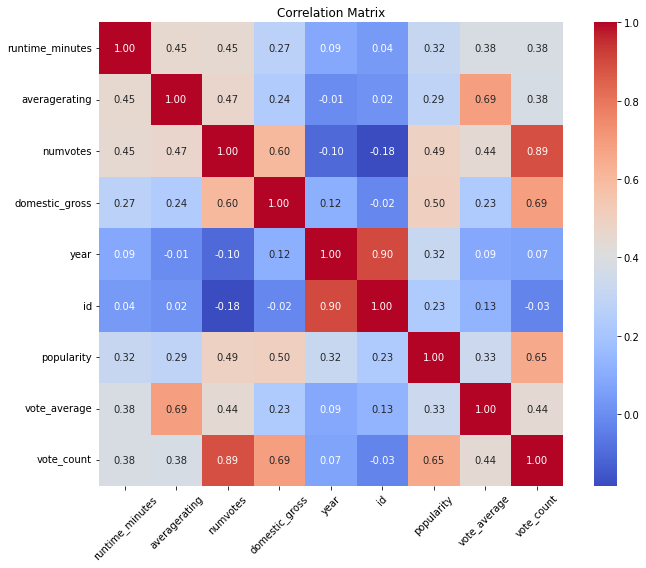

In [22]:
numeric_columns = merged_data.select_dtypes(include=[np.number]).columns

# Compute the correlation matrix
corr_matrix = merged_data[numeric_columns].corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

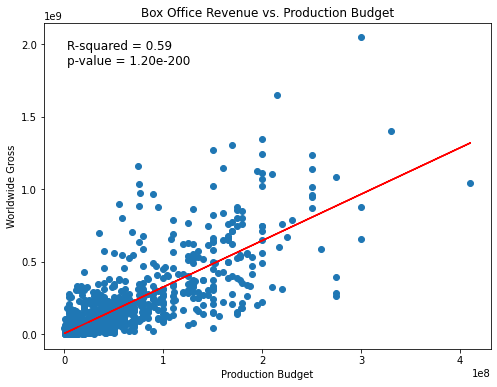

In [34]:
from scipy import stats

# box office revenue vs production budget
# Convert 'worldwide_gross' to string, remove the dollar sign and commas, and convert to numeric
merged_data['worldwide_gross'] = merged_data['worldwide_gross'].astype(str).str.replace('$', '').str.replace(',', '').astype(float)
merged_data['production_budget'] = merged_data['production_budget'].astype(str).str.replace('$', '').str.replace(',', '').astype(float)

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(merged_data['production_budget'], merged_data['worldwide_gross'])

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(merged_data['production_budget'], merged_data['worldwide_gross'])

# Plot the regression line
x = merged_data['production_budget']
y_pred = slope * x + intercept
plt.plot(x, y_pred, color='red')

# Add labels and title
plt.xlabel('Production Budget')
plt.ylabel('Worldwide Gross')
plt.title('Box Office Revenue vs. Production Budget')

# Display R-squared and p-value on the plot
plt.text(0.05, 0.95, f"R-squared = {r_value**2:.2f}\np-value = {p_value:.2e}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.show()

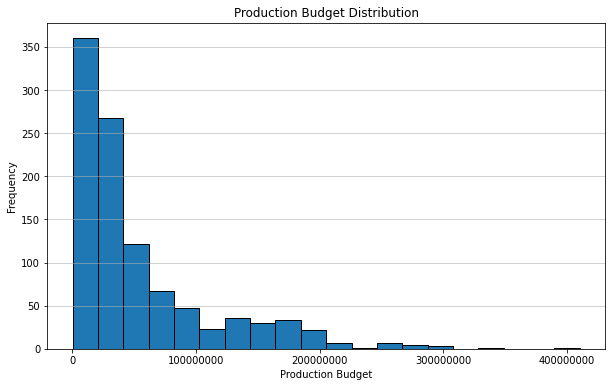

In [24]:
# distribution of production budget
# Remove rows with missing or zero production budget
valid_budget_data = merged_data[merged_data['production_budget'] > 0]

# Create a histogram of production budgets
plt.figure(figsize=(10, 6))
plt.hist(valid_budget_data['production_budget'], bins=20, edgecolor='black')
plt.xlabel('Production Budget')
plt.ylabel('Frequency')
plt.title('Production Budget Distribution')
plt.ticklabel_format(style='plain', axis='x')  # Display full numbers on the x-axis
plt.grid(axis='y', alpha=0.7)
plt.show()

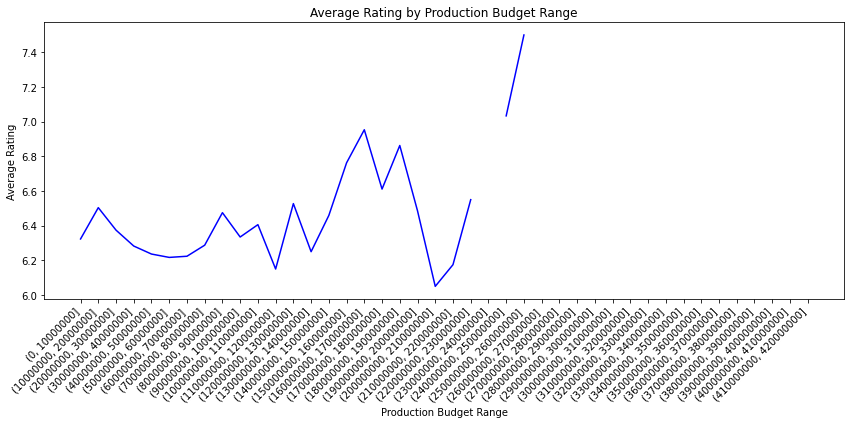

In [38]:
# Create budget bins
min_budget = 0
max_budget = int(merged_data['production_budget'].max()) + 10000000
step = 10000000
budget_bins = pd.cut(merged_data['production_budget'], bins=range(min_budget, max_budget, step))

# Calculate the average rating for each budget bin
budget_avg_rating = merged_data.groupby(budget_bins)['vote_average'].mean()

plt.figure(figsize=(12, 6))
plt.plot(budget_avg_rating.index.astype(str), budget_avg_rating.values, 'b-')

# Set x-axis labels
plt.xticks(range(len(budget_avg_rating)), budget_avg_rating.index.astype(str), rotation=45, ha='right')

# Set labels and title
plt.xlabel('Production Budget Range')
plt.ylabel('Average Rating')
plt.title('Average Rating by Production Budget Range')

plt.tight_layout()
plt.show()

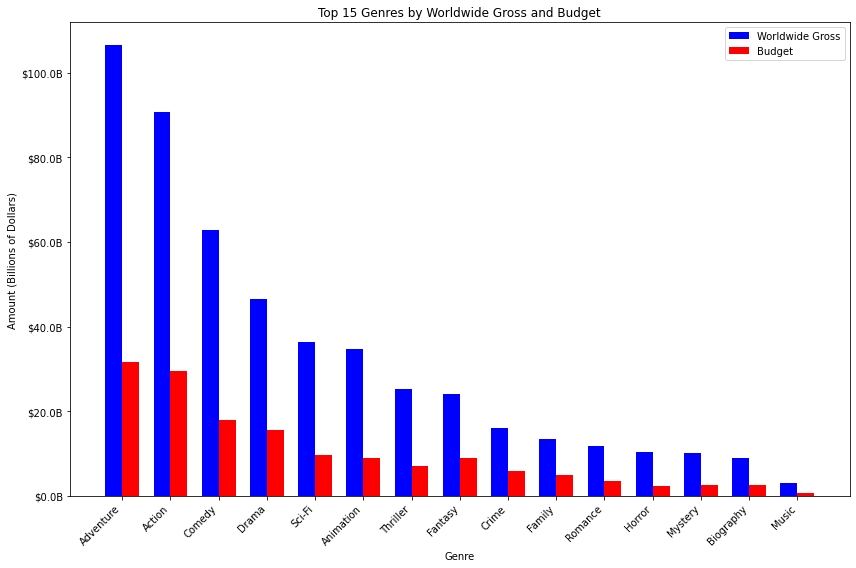

In [31]:
from matplotlib.ticker import FuncFormatter

# genre x worldwide gross
genre_data = merged_data['genres'].astype(str).str.split(',')

# Create a DataFrame with genres, worldwide gross, and budget
genre_data = pd.DataFrame({
    'genre': [genre.strip() for genres in genre_data for genre in genres if genre.strip() and genre.strip() != 'nan'],
    'worldwide_gross': np.repeat(merged_data['worldwide_gross'].values, genre_data.apply(len)),
    'budget': np.repeat(merged_data['production_budget'].values, genre_data.apply(len))
})

# Group by genre and sum the worldwide gross and budget
genre_gross = genre_data.groupby('genre')['worldwide_gross'].sum()
genre_budget = genre_data.groupby('genre')['budget'].sum()

# Select the top 15 genres by worldwide gross
top_15_genres = genre_gross.nlargest(15)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Set the width of each bar
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = np.arange(len(top_15_genres))
r2 = [x + bar_width for x in r1]

# Plot the worldwide gross and budget bars side by side
ax.bar(r1, top_15_genres.values / 1e9, color='b', width=bar_width, label='Worldwide Gross')
ax.bar(r2, genre_budget[top_15_genres.index] / 1e9, color='r', width=bar_width, label='Budget')

# Set the x-axis labels and rotate them
ax.set_xticks([r + bar_width/2 for r in range(len(top_15_genres))])
ax.set_xticklabels(top_15_genres.index, rotation=45, ha='right')

# Set the labels and title
ax.set_xlabel('Genre')
ax.set_ylabel('Amount (Billions of Dollars)')
ax.set_title('Top 15 Genres by Worldwide Gross and Budget')

# Format the y-axis tick labels to display billions of dollars
def billions_formatter(x, pos):
    return f'${x:.1f}B'

ax.yaxis.set_major_formatter(FuncFormatter(billions_formatter))

# Add a legend
ax.legend()

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

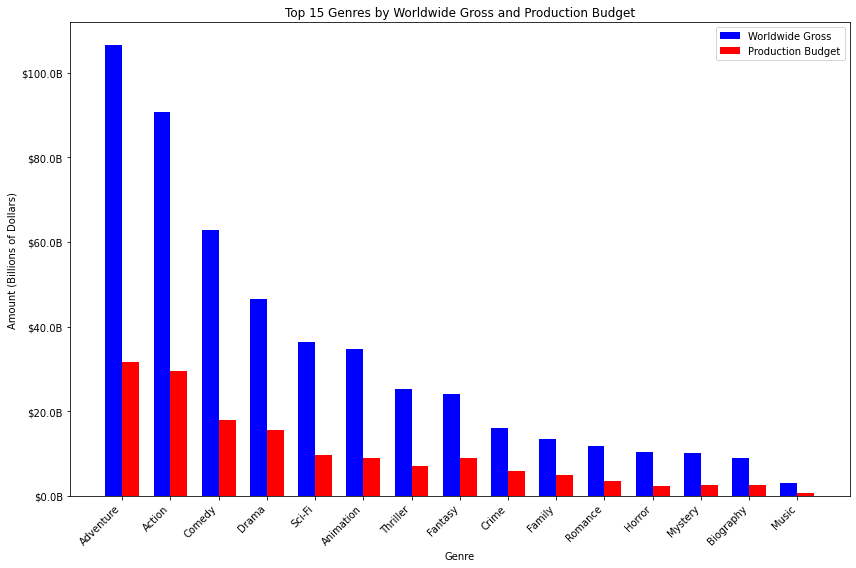

In [32]:
# genre x worldwide gross
genre_data = merged_data['genres'].astype(str).str.split(',')

# Create a DataFrame with genres, worldwide gross, and production budget
genre_data = pd.DataFrame({
    'genre': [genre.strip() for genres in genre_data for genre in genres if genre.strip() and genre.strip() != 'nan'],
    'worldwide_gross': np.repeat(merged_data['worldwide_gross'].values, genre_data.apply(len)),
    'production_budget': np.repeat(merged_data['production_budget'].values, genre_data.apply(len))
})

# Group by genre and sum the worldwide gross and production budget
genre_gross = genre_data.groupby('genre')['worldwide_gross'].sum()
genre_budget = genre_data.groupby('genre')['production_budget'].sum()

# Select the top 15 genres by worldwide gross
top_15_genres = genre_gross.nlargest(15)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Set the width of each bar
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = np.arange(len(top_15_genres))
r2 = [x + bar_width for x in r1]

# Plot the worldwide gross and production budget bars side by side
ax.bar(r1, top_15_genres.values / 1e9, color='b', width=bar_width, label='Worldwide Gross')
ax.bar(r2, genre_budget[top_15_genres.index] / 1e9, color='r', width=bar_width, label='Production Budget')

# Set the x-axis labels and rotate them
ax.set_xticks([r + bar_width/2 for r in range(len(top_15_genres))])
ax.set_xticklabels(top_15_genres.index, rotation=45, ha='right')

# Set the labels and title
ax.set_xlabel('Genre')
ax.set_ylabel('Amount (Billions of Dollars)')
ax.set_title('Top 15 Genres by Worldwide Gross and Production Budget')

# Format the y-axis tick labels to display billions of dollars
def billions_formatter(x, pos):
    return f'${x:.1f}B'

ax.yaxis.set_major_formatter(FuncFormatter(billions_formatter))

# Add a legend
ax.legend()

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

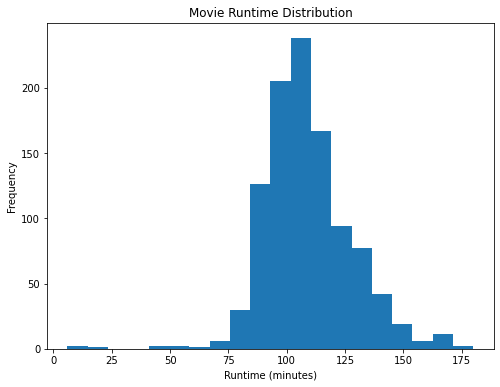

In [24]:
# movie runtime histogram
plt.figure(figsize=(8, 6))
plt.hist(merged_data['runtime_minutes'], bins=20)
plt.xlabel('Runtime (minutes)')
plt.ylabel('Frequency')
plt.title('Movie Runtime Distribution')
plt.show()

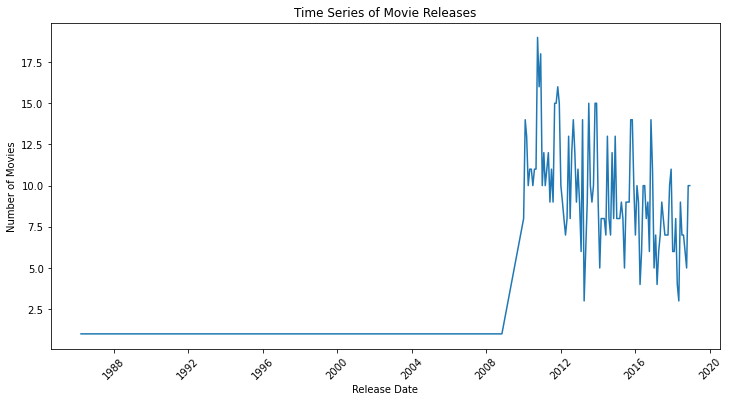

In [25]:
# time series of movie releases
merged_data['release_year_month'] = pd.to_datetime(merged_data['release_date']).dt.to_period('M')
release_counts = merged_data.groupby('release_year_month').size()
plt.figure(figsize=(12, 6))
plt.plot(release_counts.index.to_timestamp(), release_counts.values)
plt.xlabel('Release Date')
plt.ylabel('Number of Movies')
plt.title('Time Series of Movie Releases')
plt.xticks(rotation=45)
plt.show()

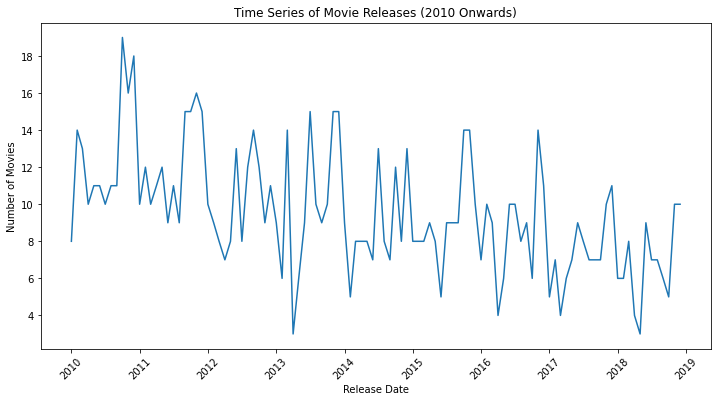

In [26]:
# As we saw in our merged_data.describe - most of our data is after 2010.
merged_data_2010_onwards = merged_data[pd.to_datetime(merged_data['release_date']).dt.year >= 2010]
merged_data_2010_onwards.loc[:, 'release_year_month'] = pd.to_datetime(merged_data_2010_onwards['release_date']).dt.to_period('M')

# Count the number of movies released in each year and month
release_counts_2010_onwards = merged_data_2010_onwards.groupby('release_year_month').size()

plt.figure(figsize=(12, 6))
plt.plot(release_counts_2010_onwards.index.to_timestamp(), release_counts_2010_onwards.values)
plt.xlabel('Release Date')
plt.ylabel('Number of Movies')
plt.title('Time Series of Movie Releases (2010 Onwards)')
plt.xticks(rotation=45)
plt.show()

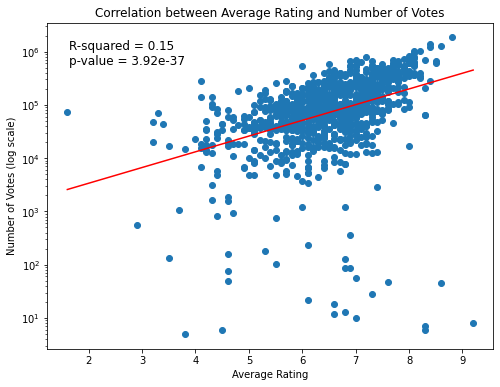

In [27]:
# correlation between avg rating and number of votes
# Remove rows with missing or invalid values
merged_data = merged_data.dropna(subset=['averagerating', 'numvotes'])

# Remove rows with zero or negative 'numvotes' values
merged_data = merged_data[merged_data['numvotes'] > 0]

plt.figure(figsize=(8, 6))
plt.scatter(merged_data['averagerating'], merged_data['numvotes'])
plt.yscale('log')  # Apply logarithmic scale to the y-axis

# Perform linear regression on the transformed data
slope, intercept, r_value, p_value, std_err = stats.linregress(merged_data['averagerating'], np.log10(merged_data['numvotes']))

# Plot the regression line
x = np.linspace(merged_data['averagerating'].min(), merged_data['averagerating'].max(), 100)
y_pred = 10 ** (intercept + slope * x)  # Compute the predicted values in the original scale
plt.plot(x, y_pred, color='red')

# Add labels and title
plt.xlabel('Average Rating')
plt.ylabel('Number of Votes (log scale)')
plt.title('Correlation between Average Rating and Number of Votes')

# Display R-squared and p-value on the plot if they are valid
if not np.isnan(r_value) and not np.isnan(p_value):
    plt.text(0.05, 0.95, f"R-squared = {r_value**2:.2f}\np-value = {p_value:.2e}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
else:
    print("Warning: R-squared and/or p-value is NaN. The regression results may not be reliable.")

plt.show()

In [28]:
# top 10 highest grossing movies
top_10_movies = merged_data.nlargest(10, 'worldwide_gross')

print("Top 10 Highest-Grossing Movies:")
print(top_10_movies[['original_title', 'worldwide_gross']])

Top 10 Highest-Grossing Movies:
                        original_title  worldwide_gross
111909          Avengers: Infinity War     2.048134e+09
47                      Jurassic World     1.648855e+09
102187         Avengers: Age of Ultron     1.403014e+09
94482                    Black Panther     1.348258e+09
113807  Jurassic World: Fallen Kingdom     1.305773e+09
13283                           Frozen     1.272470e+09
110688                   Incredibles 2     1.242521e+09
113214         The Fate of the Furious     1.234846e+09
101049                         Minions     1.160336e+09
84207                          Aquaman     1.146895e+09


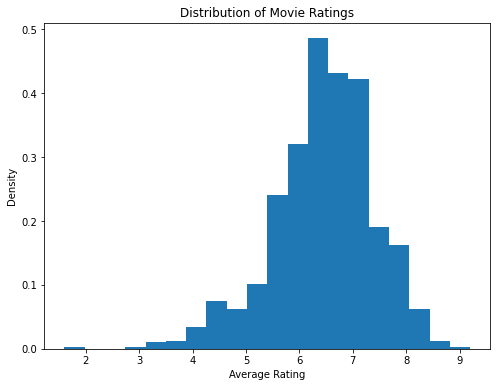

In [29]:
# distribution of movie ratings
plt.figure(figsize=(8, 6))
plt.hist(merged_data['averagerating'], bins=20, density=True)
plt.xlabel('Average Rating')
plt.ylabel('Density')
plt.title('Distribution of Movie Ratings')
plt.show()

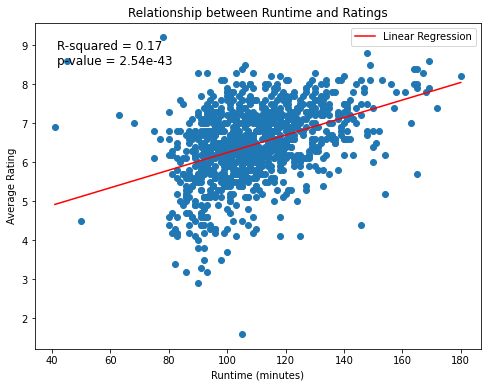

In [30]:
# runtime vs ratings
plt.figure(figsize=(8, 6))
plt.scatter(merged_data['runtime_minutes'], merged_data['averagerating'])

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(merged_data['runtime_minutes'], merged_data['averagerating'])

# Generate points for the regression line
x = np.linspace(merged_data['runtime_minutes'].min(), merged_data['runtime_minutes'].max(), 100)
y_pred = intercept + slope * x

# Plot the regression line
plt.plot(x, y_pred, color='red', label='Linear Regression')

# Add labels and title
plt.xlabel('Runtime (minutes)')
plt.ylabel('Average Rating')
plt.title('Relationship between Runtime and Ratings')

# Display R-squared and p-value on the plot
plt.text(0.05, 0.95, f"R-squared = {r_value**2:.2f}\np-value = {p_value:.2e}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.legend()
plt.show()

Next, lets explore our imdb_data dataframe

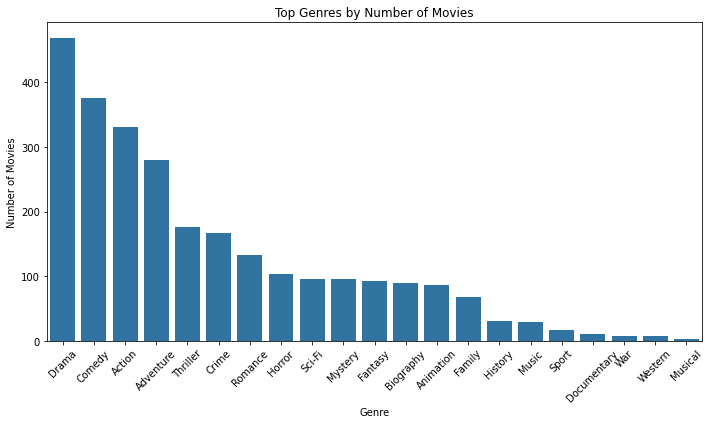

In [31]:
# top genres by number of movies
genre_counts = merged_data['genres'].str.split(',', expand=True).stack().value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.title('Top Genres by Number of Movies')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

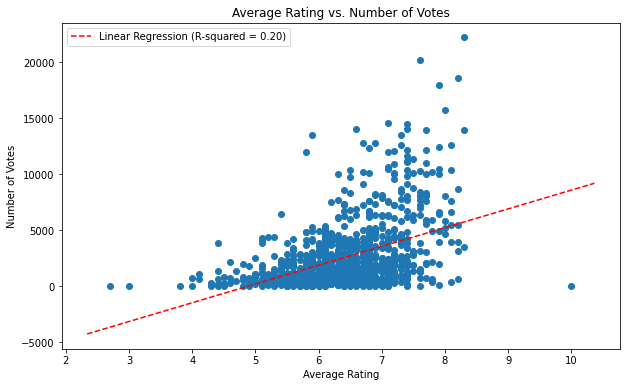

In [32]:
# average rating vs. number of votes
plt.figure(figsize=(10, 6))
plt.scatter(merged_data['vote_average'], merged_data['vote_count'])

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(merged_data['vote_average'], merged_data['vote_count'])

# Generate points for the regression line
x_vals = np.array(plt.xlim())
y_vals = intercept + slope * x_vals

# Plot the regression line
plt.plot(x_vals, y_vals, 'r--', label=f'Linear Regression (R-squared = {r_value**2:.2f})')

plt.xlabel('Average Rating')
plt.ylabel('Number of Votes')
plt.title('Average Rating vs. Number of Votes')
plt.legend()
plt.show()

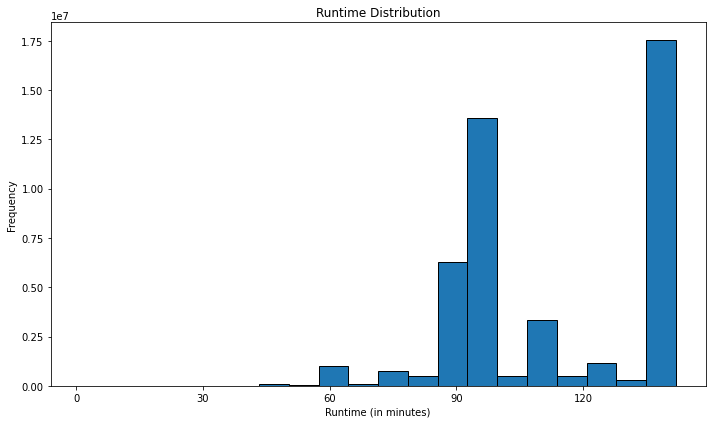

In [39]:
# runtime distribution
# Remove rows with missing or zero runtime values
cleaned_data = imdb_data[imdb_data['runtime_minutes'].notna() & (imdb_data['runtime_minutes'] > 0)]

# Calculate the 95th percentile of runtime values
percentile_95 = np.percentile(cleaned_data['runtime_minutes'], 95)

# Filter out runtime values greater than the 95th percentile
filtered_data = cleaned_data[cleaned_data['runtime_minutes'] <= percentile_95]

plt.figure(figsize=(10, 6))
plt.hist(filtered_data['runtime_minutes'], bins=20, edgecolor='black')
plt.xlabel('Runtime (in minutes)')
plt.ylabel('Frequency')
plt.title('Runtime Distribution')
plt.xticks(range(0, int(percentile_95), 30))
plt.tight_layout()
plt.show()

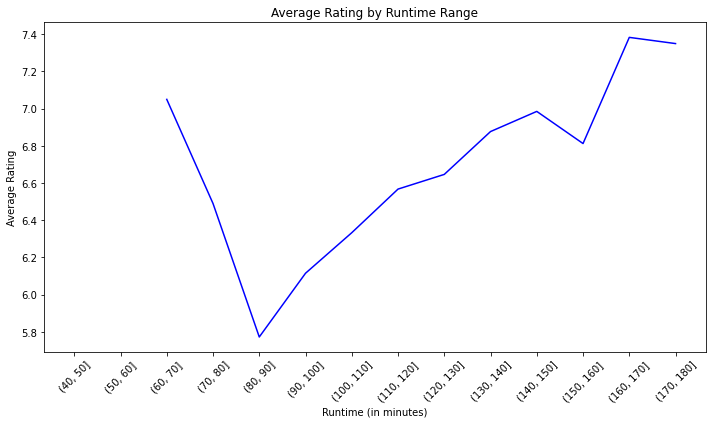

In [34]:
# runtime x avg rating
min_runtime = 0
max_runtime = int(merged_data['runtime_minutes'].max()) + 10
step = 10
runtime_bins = pd.cut(merged_data['runtime_minutes'], bins=range(min_runtime, max_runtime, step))

# Calculate the average rating for each runtime bin
runtime_avg_rating = merged_data.groupby(runtime_bins)['vote_average'].mean()

plt.figure(figsize=(10, 6))
plt.plot(runtime_avg_rating.index.astype(str), runtime_avg_rating.values, 'b-')

plt.xlabel('Runtime (in minutes)')
plt.ylabel('Average Rating')
plt.title('Average Rating by Runtime Range')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [35]:
# Top 10 Writers
print("Top 10 Writers:")
top_writers = merged_data[merged_data['writer'].notna() & (merged_data['writer'] != '')]['writer'].value_counts().nlargest(10)
for writer, count in top_writers.items():
    print(f"{writer}: {count} movies")

print()  

# Top 10 Directors
print("Top 10 Directors:")
top_directors = merged_data[~merged_data['director'].isin(['unknown', 'Unknown'])]['director'].value_counts().nlargest(10)
for director, count in top_directors.items():
    print(f"{director}: {count} movies")

Top 10 Writers:
Unknown: 7 movies
Allan Loeb: 6 movies
Adam McKay: 6 movies
Dan Gilroy: 5 movies
Amanda Silver: 5 movies
Adam Sandler: 4 movies
Jack Kirby: 4 movies
Christopher Nolan: 4 movies
Jeff Nichols: 4 movies
Luc Besson: 4 movies

Top 10 Directors:
Steven Spielberg: 7 movies
Ridley Scott: 6 movies
Clint Eastwood: 6 movies
Jon M. Chu: 5 movies
Francis Lawrence: 5 movies
Zack Snyder: 5 movies
Jaume Collet-Serra: 5 movies
Peter Berg: 5 movies
Shawn Levy: 5 movies
Steven Soderbergh: 5 movies


Number of movies may not be indicitive of how well the writer / director's work translates to the film industry. lets compare these top writers / directors with their movies ratings. 

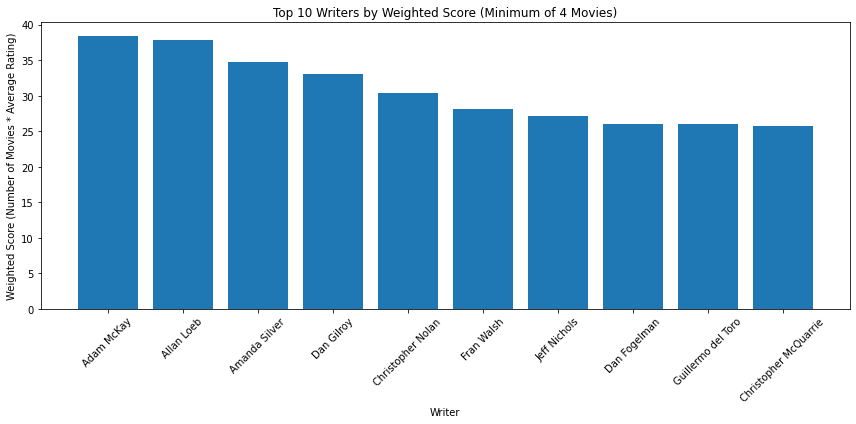

In [36]:
# Get the top 10 writers
writer_stats = merged_data[merged_data['writer'] != 'Unknown'].groupby('writer').agg({'title': 'count', 'vote_average': 'mean'}).reset_index()

# Filter out writers with less than 4 movies
writer_stats = writer_stats[writer_stats['title'] >= 4]

# Calculate a weighted score combining the number of movies and average rating
writer_stats['score'] = writer_stats['title'] * writer_stats['vote_average']

# Sort the writers based on the weighted score in descending order
writer_stats = writer_stats.sort_values('score', ascending=False)

# Get the top 10 writers based on the weighted score
top_writers = writer_stats.head(10)

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(top_writers['writer'], top_writers['score'])
plt.xlabel('Writer')
plt.ylabel('Weighted Score (Number of Movies * Average Rating)')
plt.title('Top 10 Writers by Weighted Score (Minimum of 4 Movies)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

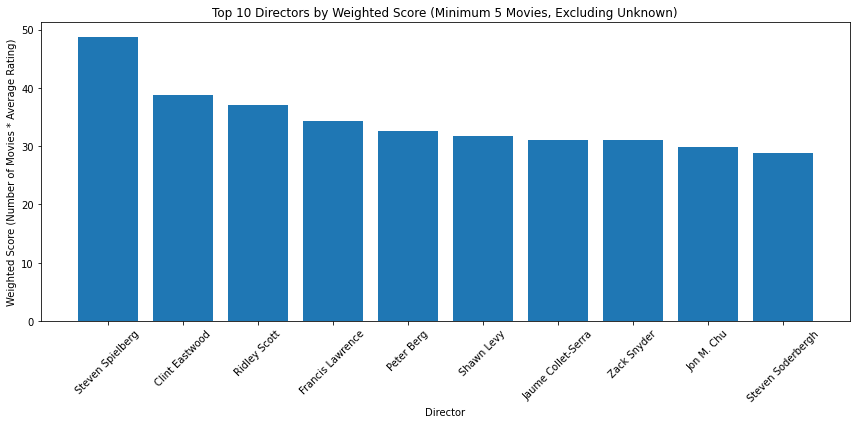

In [37]:
# Get the top 10 directors
director_stats = merged_data[~merged_data['director'].isin(['Unknown', 'unknown'])].groupby('director').agg({'title': 'count', 'vote_average': 'mean'}).reset_index()

# Filter out directors with less than 5 movies
director_stats = director_stats[director_stats['title'] >= 5]

# Calculate a weighted score combining the number of movies and average rating
director_stats['score'] = director_stats['title'] * director_stats['vote_average']

# Sort the directors based on the weighted score in descending order
director_stats = director_stats.sort_values('score', ascending=False)

# Get the top 10 directors based on the weighted score
top_directors = director_stats.head(10)

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(top_directors['director'], top_directors['score'])
plt.xlabel('Director')
plt.ylabel('Weighted Score (Number of Movies * Average Rating)')
plt.title('Top 10 Directors by Weighted Score (Minimum 5 Movies, Excluding Unknown)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

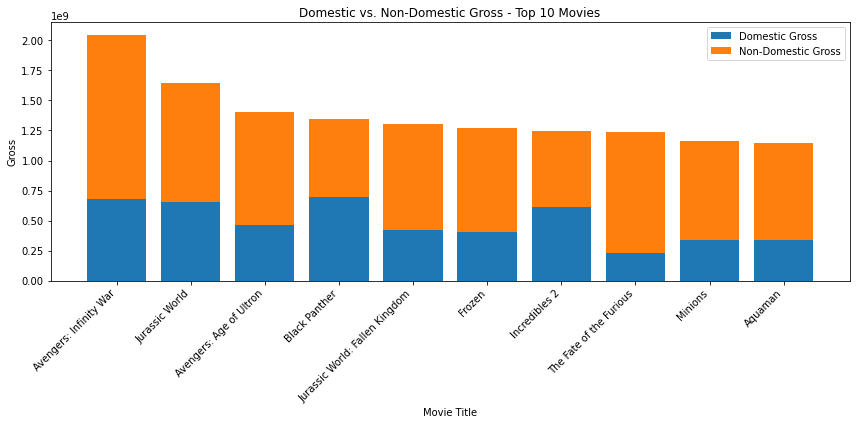

In [38]:
# Calculate non-domestic gross
merged_data['non_domestic_gross'] = merged_data['worldwide_gross'] - merged_data['domestic_gross']

# Sort the data by worldwide gross in descending order
sorted_data = merged_data.sort_values('worldwide_gross', ascending=False)

# Get the top N movies (adjust N as needed)
top_n = 10
top_movies = sorted_data.head(top_n)

# Create a stacked bar chart
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.8

# Plot domestic gross
ax.bar(top_movies['primary_title'], top_movies['domestic_gross'], bar_width, label='Domestic Gross')

# Plot non-domestic gross on top of domestic gross
ax.bar(top_movies['primary_title'], top_movies['non_domestic_gross'], bar_width,
       bottom=top_movies['domestic_gross'], label='Non-Domestic Gross')

# Add labels and title
ax.set_xlabel('Movie Title')
ax.set_ylabel('Gross')
ax.set_title(f'Domestic vs. Non-Domestic Gross - Top {top_n} Movies')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add a legend
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

## Rotten Tomatoes visualizations


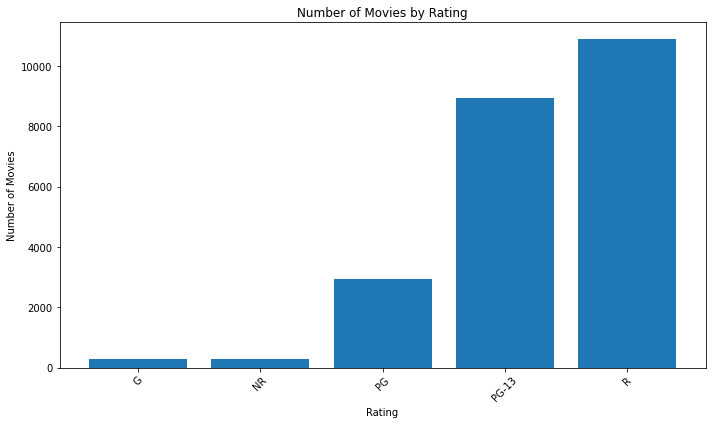

In [39]:
# distribution of movie rating
rating_performance = merged_rt_data.groupby('rating')['rating'].count()

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(rating_performance.index, rating_performance.values)
plt.xlabel('Rating')
plt.ylabel('Number of Movies')
plt.title('Number of Movies by Rating')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

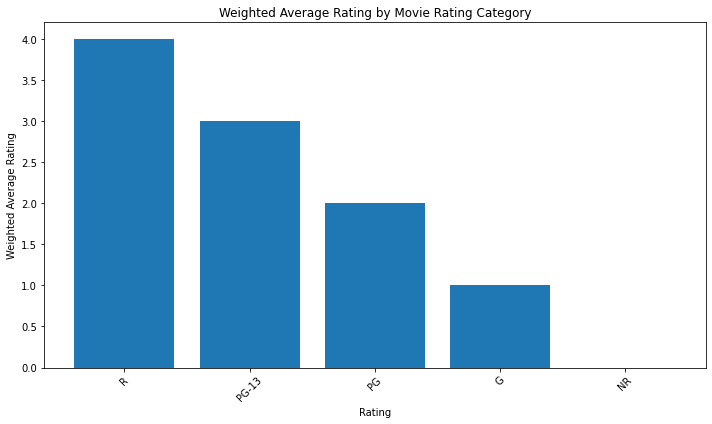

In [40]:
rating_mapping = {
    'G': 1,
    'PG': 2,
    'PG-13': 3,
    'R': 4,
    'NC-17': 5,
    'Not Rated': 6
}

# Convert rating categories to numeric values
merged_rt_data['numeric_rating'] = merged_rt_data['rating'].map(rating_mapping)

# Calculate the weighted average rating for each rating category
rating_counts = merged_rt_data['rating'].value_counts()
weighted_average = (merged_rt_data.groupby('rating')['numeric_rating'].sum() / rating_counts).sort_values(ascending=False)

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(weighted_average.index, weighted_average.values)
plt.xlabel('Rating')
plt.ylabel('Weighted Average Rating')
plt.title('Weighted Average Rating by Movie Rating Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

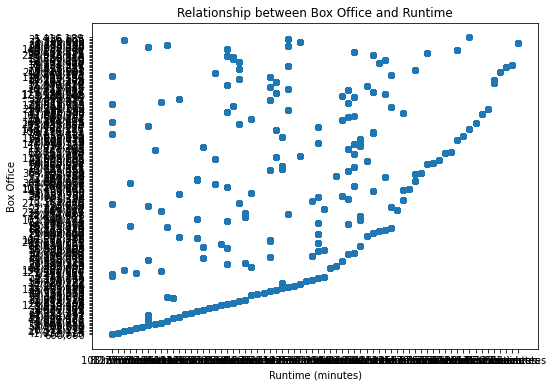

In [41]:
# relationship between box office and runtime
plt.figure(figsize=(8, 6))
plt.scatter(merged_rt_data['runtime'], merged_rt_data['box_office'])
plt.xlabel('Runtime (minutes)')
plt.ylabel('Box Office')
plt.title('Relationship between Box Office and Runtime')
plt.show()

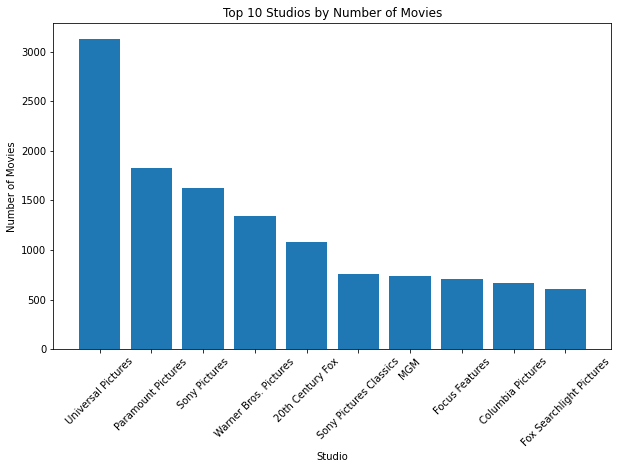

In [42]:
# top 10 studios by number of movies
top_studios = merged_rt_data['studio'].value_counts().nlargest(10)

plt.figure(figsize=(10, 6))
plt.bar(top_studios.index, top_studios.values)
plt.xlabel('Studio')
plt.ylabel('Number of Movies')
plt.title('Top 10 Studios by Number of Movies')
plt.xticks(rotation=45)
plt.show()

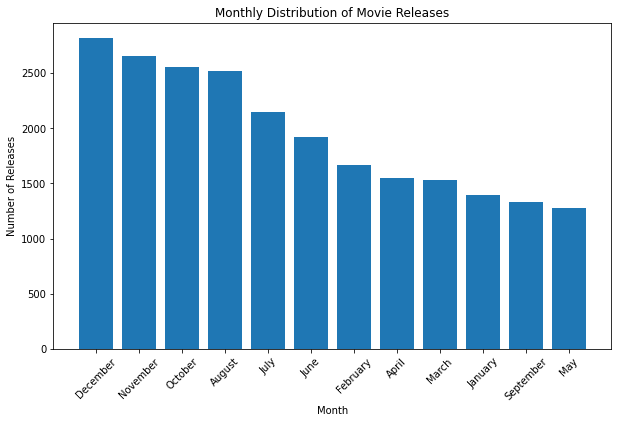

In [43]:
# monthly distribution of movie releases
merged_rt_data['release_month'] = pd.to_datetime(merged_rt_data['theater_date']).dt.month_name()

monthly_releases = merged_rt_data['release_month'].value_counts()

plt.figure(figsize=(10, 6))
plt.bar(monthly_releases.index, monthly_releases.values)
plt.xlabel('Month')
plt.ylabel('Number of Releases')
plt.title('Monthly Distribution of Movie Releases')
plt.xticks(rotation=45)
plt.show()

In [ ]:
tn_budgets.head()